In [1]:
import random
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from hiv_patient import HIVPatient
from sklearn.ensemble import ExtraTreesRegressor , RandomForestRegressor
from copy import deepcopy

In [2]:
def greedy_action(tree, state, env):
    rew = []
    for j in range(4):
        input_a = np.zeros((1, 8))
        input_a[:, :6] = state
        input_a[:, 6:] = env.action_set[j]
        rew.append(tree.predict(input_a))

    return np.argmax(rew)

In [4]:
# Replay buffer class
class ReplayBuffer:
    def __init__(self, 
                 env,
                 gamma=0.98,
                 epsilon=0.15,
                 nb_actions=4,
                 nb_patient=30,
                 duration=200):
        

        self.env = env
        self.gamma = gamma 
        self.epsilon = epsilon
        self.nb_actions = nb_actions
        self.nb_patients = nb_patient
        self.duration = duration
        self.data = np.zeros((self.duration * self.nb_patients, 15))


        print('Initializing replay buffer RB_0:')
        for j in tqdm(range(self.nb_patients)):
            self.env.reset(mode="unhealthy")
            for k in range(self.duration):
                s = self.env.state()
                idx_a = np.random.randint(self.nb_actions)
                a = self.env.action_set[idx_a]
                s_, r, _, _ = self.env.step(idx_a)

                # state size 6,  action size 2,  reward size 1
                self.data[j*self.duration + k, : 6] = s # state
                self.data[j*self.duration + k, 6:8] = a # action
                self.data[j*self.duration + k, 8] = r # reward
                self.data[j*self.duration + k, 9: ]  = s_ # new state


    def update_set(self, tree, data):
        self.data_new = np.zeros((self.duration * self.nb_patients, 15))
        for j in range(self.nb_patients):
            self.env.reset()
            for k in range(self.duration):
                # epsilon greedy
                s = self.env.state() 
                if np.random.rand() < self.epsilon:
                    idx_a = np.random.randint(self.nb_actions)

                else :
                    idx_a = greedy_action(tree, s, self.env)
                
                
                a = self.env.action_set[idx_a]
                s_, r, _, _ = self.env.step(idx_a)
                self.data_new[j*self.duration + k, : 6] = s # state
                self.data_new[j*self.duration + k, 6:8] = a # action
                self.data_new[j*self.duration + k, 8] = r  # reward
                self.data_new[j*self.duration + k, 9: ] = s_ # new state
                
        update_data = np.concatenate([data, self.data_new])
        
        return update_data


    def __len__(self):
        return len(self.data)

In [13]:
class ExtraTree:
    def __init__(self, 
                 config,
                 env,
                 nb_epoch) -> None:
        self.env = env
        self.nb_epoch = nb_epoch
        self.duration = config['duration']
        self.nb_patient = config['nb_patients']
        self.gamma = config['gamma']
        self.buffer = ReplayBuffer(env,
                                 gamma=self.gamma,
                                 epsilon=0.15,
                                 nb_actions=len(self.env.action_set),
                                 duration=self.duration, 
                                 nb_patient=self.nb_patient)
        self.data = self.buffer.data
        self.Qtree = ExtraTreesRegressor(n_estimators=50)
        # self.Qtree = RandomForestRegressor(n_estimators=100)


        self.checkpoints = []
        self.cumulated_rewards = []
    
    def train(self):

        # First step
        X, y = self.data[:, :8], self.data[:, 8]
        self.Qtree.fit(X,y)
        self.checkpoints.append(deepcopy(self.Qtree))

        for epoch in tqdm(range(self.nb_epoch-1)):

            #We update the training set
            self.data = self.buffer.update_set(self.Qtree, self.data)

            X_ = np.zeros((self.data.shape[0], 8))
            X_[:, :6]= self.data[:, 9:] # s prime
            y_res = np.zeros((self.data.shape[0], 4)) # taking result of each action

            # We loop on all possible actions 
            for idx_a in range(4):
                a = self.env.action_set[idx_a]
                X_[:, 6:] = a
                y_pred = self.Qtree.predict(X_)
                y_res[:, idx_a] = y_pred

            # We take the argmax and update our training set
            idx_max = np.argmax(y_res, axis=1)
            target = self.data[:, 8] + self.gamma * np.take_along_axis(y_res, idx_max[:,None], axis=1)[:, 0]
            

            # fitting the tree with the new training set
            X, y = self.data[:, :8], target
            self.Qtree.fit(X,y)
            self.checkpoints.append(deepcopy(self.Qtree))

    def test(self):
        nb_trees = len(self.checkpoints)
        actions = np.zeros((1+nb_trees, self.duration))
        states = np.zeros((1+nb_trees, self.duration, 6))
        self.cumulated_rewards = []
        for i in trange(nb_trees+1):
            self.env.reset(mode="unhealthy")
            cum_reward_tree = 0
            for k in range(self.duration):
                s = self.env.state()
                y_res = []
                if i == 0: # Random behaviour
                    idx_a = np.random.randint(4)

                else: # Fitted Q Tree
                    for idx_a in range(4):
                        a = self.env.action_set[idx_a]
                        y_pred = self.checkpoints[i-1].predict(np.concatenate([s,a]).reshape(1, -1))
                        y_res.append(y_pred)
                    idx_a = np.argmax(y_res)
                    
                a = self.env.action_set[idx_a]
                s_, r, _, _ = self.env.step(idx_a)
                cum_reward_tree += r
                actions[i, k] = idx_a
                states[i, k, :] = s

            self.cumulated_rewards.append(cum_reward_tree)
        return actions, states, self.cumulated_rewards


In [6]:
patient = HIVPatient()
config_test = {'gamma': 0.98,
               'nb_patients': 30,
               'duration': 200 }


# Tree_test = ExtraTree(config=config_test,
#                       env=patient,
#                       nb_epoch= 10)

In [36]:
Tree_test.train()

100%|██████████| 9/9 [19:41<00:00, 131.33s/it]


In [38]:
actions, states, cum_reward = Tree_test.test()

100%|██████████| 11/11 [00:46<00:00,  4.26s/it]


In [37]:
import pickle
filename = 'model_extratree_50.sav'
pickle.dump(Tree_test, open(filename, 'wb'))

In [14]:
import pickle
filename = 'model_extratree_100_13ep.sav'
tree_trained = pickle.load(open(filename, 'rb'))

In [15]:
tree_trained.cumulated_rewards = []
actions, states, cum_reward = tree_trained.test()

100%|██████████| 14/14 [01:10<00:00,  5.04s/it]


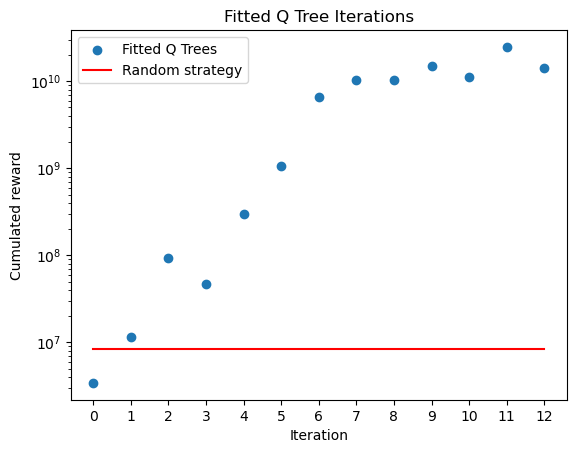

In [16]:
plt.scatter(range(len(cum_reward)-1),cum_reward[1:], label='Fitted Q Trees')
plt.plot(range(len(cum_reward)-1), [cum_reward[0] for i in range(len(cum_reward)-1)], label='Random strategy', color='red')
plt.xlabel('Iteration')
plt.ylabel('Cumulated reward')
plt.title('Fitted Q Tree Iterations')
plt.xticks(range(len(cum_reward)-1))
plt.yscale(value='log')
plt.legend()

In [17]:
env = HIVPatient()
env.reset(mode="unhealthy")
actions_base = np.zeros((200,1))
states_base = np.zeros((200,6))
cum_reward_base = 0
for k in range(200):
    s = env.state()
    y_res = []
    s_, r, _, _ = env.step(0)
    cum_reward_base += r
    actions_base[k] = 0
    states_base[k, :] = s

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


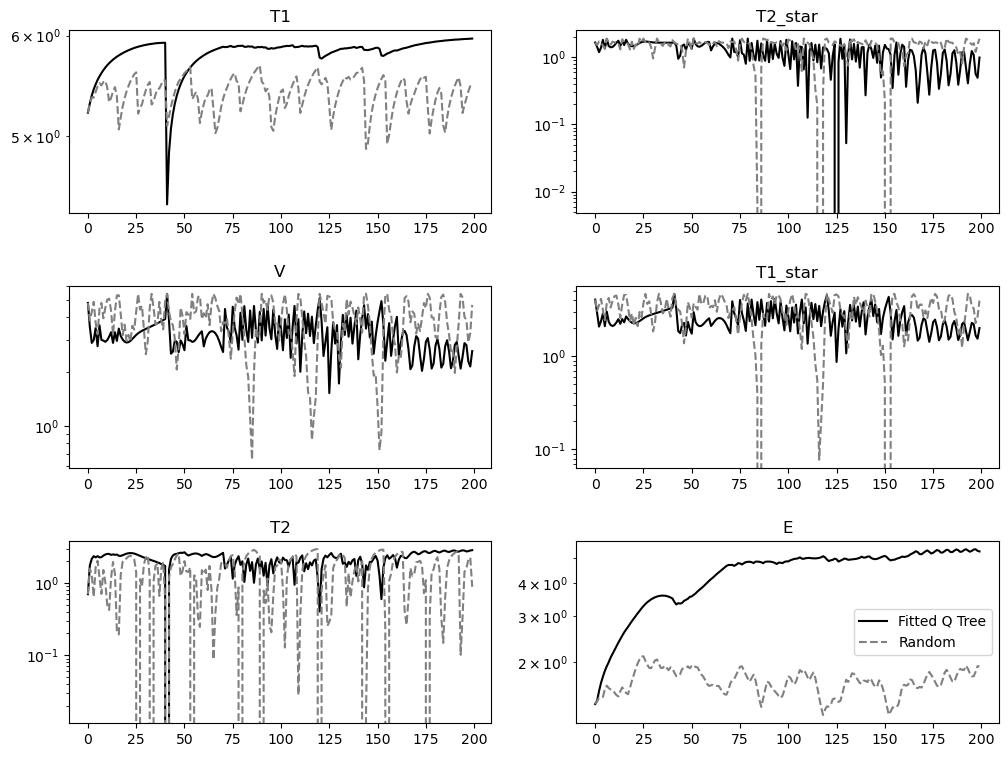

In [18]:
from itertools import cycle
cycol = cycle('bgrcmk')


def plot_tree(states, tree_number):
    list_var = ["T1", "T1_star", "T2", "T2_star", "V", "E"]
    fig, axs = plt.subplots(3, 2, figsize = (12,9))
    plt.subplots_adjust(wspace=0.2,hspace=0.4)
    for idx, var in enumerate(list_var):
        color = next(cycol)
        # Fitted Q tree 
        axs[idx % 3][idx % 2].plot(np.log10(states[tree_number, :, idx]), c="black", label="Fitted Q Tree")
        axs[idx % 3][idx % 2].set_title(var)
        axs[idx % 3][idx % 2].set_yscale('log')

        # Random action
        axs[idx % 3][idx % 2].plot(np.log10(states[0, :, idx]), c="grey",linestyle="dashed", label="Random")
        axs[idx % 3][idx % 2].set_title(var)
        axs[idx % 3][idx % 2].set_yscale('log')


        # No action
        # axs[idx % 3][idx % 2].plot(np.log10(states_base[:, idx]), c="black",linestyle = "dashdot", label="No action")
        # axs[idx % 3][idx % 2].set_title(var)
        # axs[idx % 3][idx % 2].set_yscale('log')

        plt.legend()




def plot_variable(states, variable_number):
    for i in range(states.shape[0]):
        plt.plot(np.log10(states[i, :, variable_number]))

plot_tree(states, 10)

In [19]:
# plt.plot(range(200),actions[9,:], alpha=0.5)

med1 = [0 if x % 2==0 else 1 for x in actions[8,:]]

med2 = [0 if x <2 else 1 for x in actions[8,:]]


Text(0.5, 1.0, 'PI (Protease Inhibitors)')

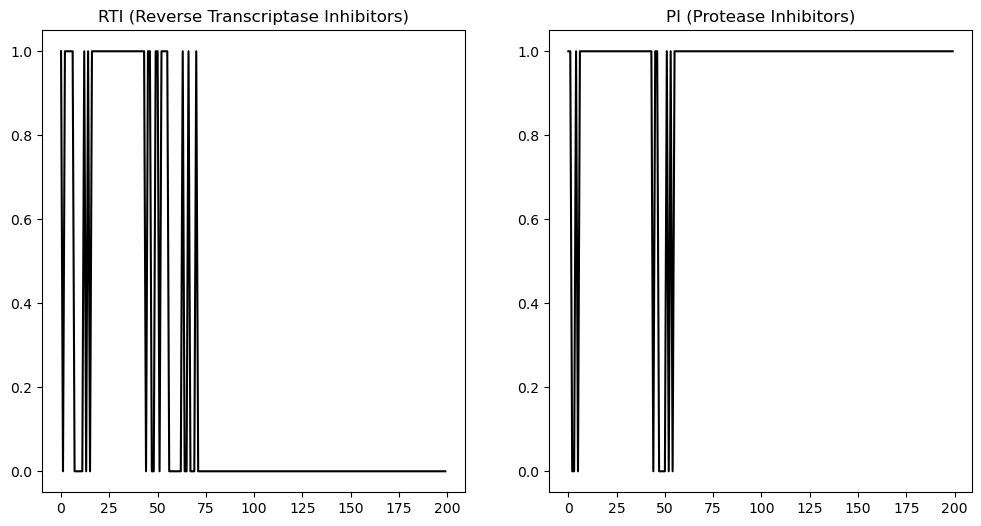

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (12,6))
plt.subplots_adjust(wspace=0.2,hspace=0.4)

axs[0].plot(med1, c="black")
axs[0].set_title("RTI (Reverse Transcriptase Inhibitors)")


# Random action
axs[1].plot(med2, c="black")
axs[1].set_title("PI (Protease Inhibitors)")


